# HalluLens - Analyse correlation hallucination (notebook propre)

Ce notebook construit un **catalogue de runs**, normalise les **prompts** et calcule des **metriques de hallucination** au niveau prompt, puis realise des comparaisons **strictement appariees** (memes prompts ou memes instances) afin d'eviter tout biais de taille d'echantillon ou de prompt sets non comparables.


In [1]:
import os
import json
import hashlib
import itertools
import warnings
from pathlib import Path

# Make matplotlib/fontconfig caches writable (helps in sandboxed envs).
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
os.environ.setdefault('MPLCONFIGDIR', str(ARTIFACTS_DIR / '.mplconfig'))
os.environ.setdefault('XDG_CACHE_HOME', str(ARTIFACTS_DIR / '.cache'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
    HAVE_SNS = True
except Exception as e:
    HAVE_SNS = False
    print('Seaborn unavailable:', e)

warnings.filterwarnings('ignore', message='Pandas requires version')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


In [2]:
from pathlib import Path

OUTPUT_ROOTS = [
    Path('../output/longwiki-hybrid'), #etude des différences entre meme sujet mis tache différente
    # Path('../output/longwiki-hybrid2'), # etude teste entre les models
    # Path('../output/longwiki-hybrid300'), # etude du noms de mots dans la reponse et température
]

LENGTH_FILTER = None  # ex: [50, 150, 300]
TASK_FILTER = None    # ex: ['INTERVIEW', 'NEWS_ARTICLE']
REQUIRE_OUTPUT_CSV = True
STRICT_MATCHING = True
TASKS_FOCUS = ['INTERVIEW', 'NEWS_ARTICLE', 'LESSON_PLAN']

BOOTSTRAP_ITERS = 2000
BOOTSTRAP_SEED = 7

import json
import hashlib
import itertools
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
    HAVE_SNS = True
except Exception as e:
    HAVE_SNS = False
    print('Seaborn unavailable:', e)

warnings.filterwarnings('ignore', message='Pandas requires version')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

GEN_CACHE = {}


def warn(msg: str):
    print(f"[WARN] {msg}")


def hash_text(s: str) -> str:
    return hashlib.sha256(s.encode('utf-8')).hexdigest()


def hash_list(items) -> str:
    # Length-prefixed join to avoid ambiguous concatenations
    joined = "".join(f"{len(str(x))}:{x}\n" for x in items)
    return hash_text(joined)



def to_list(x):
    if x is None:
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, tuple):
        return list(x)
    if isinstance(x, str):
        s = x.strip()
        # Sometimes args are stored as a JSON list inside a string.
        if s.startswith('[') and s.endswith(']'):
            try:
                parsed = json.loads(s)
                if isinstance(parsed, list):
                    return parsed
            except Exception:
                pass
        # Fallback: comma-separated string (e.g. "A, B, C").
        parts = [p.strip() for p in s.split(',')]
        parts = [p.strip("''") for p in parts if p.strip()]
        return parts
    return [x]


def normalize_model_name(rc: dict) -> str:
    if not isinstance(rc, dict):
        return None
    args = rc.get('args', {}) if isinstance(rc.get('args', {}), dict) else {}
    name = rc.get('model_name') or args.get('model') or args.get('llm')
    if not name:
        return None
    name = str(name)
    if '/' in name:
        name = name.split('/')[-1]
    return name


def read_json(path: Path) -> dict:
    try:
        return json.loads(Path(path).read_text())
    except Exception as e:
        warn(f"Failed to read JSON {path}: {e}")
        return {}


def load_jsonl(path: Path):
    rows = []
    try:
        with Path(path).open('r', encoding='utf-8') as f:
            for i, line in enumerate(f, 1):
                line = line.strip()
                if not line:
                    continue
                try:
                    rows.append(json.loads(line))
                except Exception as e:
                    warn(f"{path} line {i} JSON error: {e}")
    except FileNotFoundError:
        warn(f"Missing file: {path}")
    return rows


def load_generation_df(path: Path) -> pd.DataFrame:
    path = Path(path)
    if path in GEN_CACHE:
        return GEN_CACHE[path].copy()
    rows = load_jsonl(path)
    df = pd.DataFrame(rows)
    GEN_CACHE[path] = df
    return df.copy()


def ensure_generation_columns(df: pd.DataFrame, run_info: dict) -> pd.DataFrame:
    df = df.copy()
    # prompt
    if 'prompt' not in df.columns:
        df['prompt'] = None
    # title / task / creativity_level
    if 'title' not in df.columns:
        df['title'] = None
    if 'task' not in df.columns:
        df['task'] = None
    if 'creativity_level' not in df.columns:
        if 'creativity' in df.columns:
            df['creativity_level'] = df['creativity']
        else:
            df['creativity_level'] = None
    # generation (model response)
    if 'generation' not in df.columns:
        df['generation'] = None
    # length_words
    if 'length_words' not in df.columns:
        df['length_words'] = run_info.get('length_words') if isinstance(run_info, dict) else None
    # normalize prompt
    df['prompt_clean'] = df['prompt'].astype(str).str.strip()
    return df


def compute_prompt_ids(df: pd.DataFrame) -> pd.Series:
    return df['prompt_clean'].astype(str).map(hash_text)


def compute_instance_ids(df: pd.DataFrame) -> pd.Series:
    required = ['title', 'task', 'creativity_level']
    if not all(col in df.columns for col in required):
        return pd.Series([None] * len(df))
    complete = df[required].notna().all(axis=1)
    keys = df[required].astype(str).agg('||'.join, axis=1)
    ids = [hash_text(k) if ok else None for k, ok in zip(keys, complete)]
    return pd.Series(ids)


def compute_prompt_set_id(prompts) -> str:
    prompts = [p for p in prompts if p is not None]
    if not prompts:
        return None
    # set-based, stable
    return hash_list(sorted(set(prompts)))


def compute_instance_set_id(instance_ids) -> str:
    instance_ids = [i for i in instance_ids if i]
    if not instance_ids:
        return None
    return hash_list(sorted(set(instance_ids)))


def build_run_catalog(output_roots, length_filter=None, task_filter=None, require_output_csv=True):
    rows = []
    for root in output_roots:
        root = Path(root)
        if not root.exists():
            warn(f"Missing output root: {root}")
            continue
        for run_dir in sorted(root.iterdir()):
            if not run_dir.is_dir():
                continue

            run_config_path = run_dir / 'run_config.json'
            generation_path = run_dir / 'generation.jsonl'
            output_csv_path = run_dir / 'output.csv'

            rc = read_json(run_config_path) if run_config_path.exists() else {}
            args = rc.get('args', {}) if isinstance(rc.get('args', {}), dict) else {}

            model_name = normalize_model_name(rc)
            if model_name is None and isinstance(args, dict):
                model_name = normalize_model_name({'args': args})

            temperature = args.get('temperature')
            length_words = args.get('length_words')
            prompt_seed = args.get('prompt_seed')
            N = args.get('N')
            tasks = args.get('tasks') or rc.get('tasks')
            tasks_list = to_list(tasks)
            tasks_key = '|'.join(tasks_list) if tasks_list else None

            has_generation = generation_path.exists()
            has_output_csv = output_csv_path.exists()

            n_prompts = None
            n_prompts_in_output = None
            n_prompts_with_metrics = None

            prompt_set_id = None
            instance_set_id = None
            n_prompt_duplicates = None
            missing_instance_fields = None

            if has_generation:
                df_gen = load_generation_df(generation_path)
                df_gen = ensure_generation_columns(df_gen, {'length_words': length_words})
                prompts = df_gen['prompt_clean'].dropna().astype(str).tolist()
                n_prompts = len(prompts)
                prompt_set_id = compute_prompt_set_id(prompts)
                n_prompt_duplicates = pd.Series(prompts).duplicated().sum()
                metrics = load_output_metrics(output_csv_path)
                if not metrics.empty:
                    n_prompts_in_output = metrics['prompt_clean'].nunique()
                    n_prompts_with_metrics = metrics['support_rate'].notna().sum()


                instance_ids = compute_instance_ids(df_gen)
                if instance_ids.isna().any():
                    missing_instance_fields = True
                    instance_set_id = None
                else:
                    instance_set_id = compute_instance_set_id(instance_ids.tolist())
            else:
                n_prompts = 0
                n_prompts_in_output = 0
                n_prompts_with_metrics = 0

            # filtering flags
            passes_length = True
            if length_filter is not None:
                passes_length = length_words in length_filter

            passes_task = True
            if task_filter is not None:
                if not tasks_list:
                    passes_task = False
                else:
                    passes_task = all(t in tasks_list for t in task_filter)

            passes_filters = passes_length and passes_task

            # completeness
            is_complete = has_generation and (has_output_csv or (not require_output_csv))
            reason = []
            if not run_config_path.exists():
                reason.append('missing run_config.json')
            if not has_generation:
                reason.append('missing generation.jsonl')
            if require_output_csv and not has_output_csv:
                reason.append('missing output.csv')
            incomplete_reason = '; '.join(reason) if reason else ''

            rows.append({
                'root': str(root),
                'run_dir': run_dir.name,
                'run_path': str(run_dir),
                'run_id': f"{root.name}/{run_dir.name}",
                'run_config_path': str(run_config_path),
                'generation_path': str(generation_path),
                'output_csv_path': str(output_csv_path),
                'model_name': model_name,
                'temperature': temperature,
                'length_words': length_words,
                'tasks': tasks_list,
                'tasks_key': tasks_key,
                'prompt_seed': prompt_seed,
                'N': N,
                'has_generation': has_generation,
                'has_output_csv': has_output_csv,
                'is_complete': is_complete,
                'n_prompts': n_prompts,
                'n_prompts_in_output': n_prompts_in_output,
                'n_prompts_with_metrics': n_prompts_with_metrics,
                'prompt_set_id': prompt_set_id,
                'instance_set_id': instance_set_id,
                'n_prompt_duplicates': n_prompt_duplicates,
                'missing_instance_fields': missing_instance_fields,
                'passes_filters': passes_filters,
                'incomplete_reason': incomplete_reason,
            })

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values(['model_name', 'length_words', 'temperature', 'root', 'run_dir'])
    return df


def load_output_metrics(output_csv_path: Path) -> pd.DataFrame:
    output_csv_path = Path(output_csv_path)
    if not output_csv_path.exists():
        return pd.DataFrame(columns=['prompt_clean', 'n_claims', 'support_rate', 'hallucination_rate'])

    df_out = pd.read_csv(output_csv_path)
    if 'prompt' not in df_out.columns:
        warn(f"output.csv missing 'prompt' column: {output_csv_path}")
        return pd.DataFrame(columns=['prompt_clean', 'n_claims', 'support_rate', 'hallucination_rate'])

    df_out['prompt_clean'] = df_out['prompt'].astype(str).str.strip()

    if 'is_supported' not in df_out.columns:
        warn(f"output.csv missing 'is_supported' column: {output_csv_path}")
        return pd.DataFrame(columns=['prompt_clean', 'n_claims', 'support_rate', 'hallucination_rate'])

    is_supported = df_out['is_supported']
    if is_supported.dtype == object:
        is_supported = is_supported.astype(str).str.lower().map({'true': 1.0, 'false': 0.0})
    is_supported = pd.to_numeric(is_supported, errors='coerce')
    df_out['_is_supported_num'] = is_supported

    grouped = df_out.groupby('prompt_clean')['_is_supported_num']
    metrics = (
        grouped.agg(
            n_rows='size',      # lignes totales (incluant no-claims)
            n_claims='count',   # claims valides uniquement
            support_rate='mean'
        )
        .reset_index()
    )
    metrics['hallucination_rate'] = 1 - metrics['support_rate']
    return metrics



def build_df_prompts(df_runs: pd.DataFrame, require_output_csv=True) -> pd.DataFrame:
    frames = []
    for _, run in df_runs.iterrows():
        if not run.get('has_generation', False):
            continue
        if require_output_csv and not run.get('has_output_csv', False):
            continue

        df_gen = load_generation_df(run['generation_path'])
        df_gen = ensure_generation_columns(df_gen, run)

        df_gen['prompt_id'] = compute_prompt_ids(df_gen)
        df_gen['instance_id'] = compute_instance_ids(df_gen)

        # metrics
        if run.get('has_output_csv', False):
            metrics = load_output_metrics(run['output_csv_path'])
            df_gen = df_gen.merge(metrics, on='prompt_clean', how='left')
        else:
            df_gen['n_claims'] = np.nan
            df_gen['support_rate'] = np.nan
            df_gen['hallucination_rate'] = np.nan

        # add run-level columns
        for col in [
            'root', 'run_dir', 'run_path', 'run_id',
            'model_name', 'temperature', 'length_words',
            'tasks', 'tasks_key', 'prompt_seed', 'N',
            'prompt_set_id', 'instance_set_id'
        ]:
            val = run.get(col)
            # Convert lists to tuples to avoid broadcasting issues
            # but wrap in a list with proper length for assignment
            if isinstance(val, list):
                val = tuple(val)
            # Assign scalar value to entire column
            df_gen[col] = [val] * len(df_gen)

        frames.append(df_gen)

    if not frames:
        return pd.DataFrame()

    df_prompts = pd.concat(frames, ignore_index=True)
    return df_prompts



COMPARISONS = []


def bootstrap_ci(values, n_boot=BOOTSTRAP_ITERS, seed=BOOTSTRAP_SEED):
    values = np.asarray(values, dtype=float)
    values = values[~np.isnan(values)]
    if len(values) == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = rng.choice(values, size=(n_boot, len(values)), replace=True)
    stats = np.mean(boots, axis=1)
    return np.percentile(stats, [2.5, 97.5])


def paired_diffs(df_a, df_b, id_col, metric_col='hallucination_rate'):
    merged = df_a[[id_col, metric_col]].merge(
        df_b[[id_col, metric_col]],
        on=id_col,
        suffixes=('_a', '_b')
    )
    merged = merged.dropna()
    diffs = merged[f'{metric_col}_b'] - merged[f'{metric_col}_a']
    return merged, diffs


def summarize_diffs(diffs):
    diffs = np.asarray(diffs, dtype=float)
    diffs = diffs[~np.isnan(diffs)]
    if len(diffs) == 0:
        return {
            'n_paired': 0,
            'mean_diff': np.nan,
            'median_diff': np.nan,
            'ci_low': np.nan,
            'ci_high': np.nan,
        }
    ci_low, ci_high = bootstrap_ci(diffs)
    return {
        'n_paired': len(diffs),
        'mean_diff': float(np.mean(diffs)),
        'median_diff': float(np.median(diffs)),
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
    }


def add_comparison(result: dict):
    COMPARISONS.append(result)


def condition_prompt_means(df: pd.DataFrame, condition_cols, id_col='prompt_id'):
    return (
        df.groupby(condition_cols + [id_col], as_index=False)['hallucination_rate']
        .mean()
    )


def availability_grid(df_runs_group):
    if df_runs_group.empty:
        return pd.DataFrame()
    # grid by model x temperature x length
    grid = (
        df_runs_group
        .groupby(['model_name', 'length_words', 'temperature'])
        .size()
        .reset_index(name='n_runs')
    )
    return grid


## 1) Catalogue des runs


In [3]:
df_runs = build_run_catalog(
    OUTPUT_ROOTS,
    length_filter=LENGTH_FILTER,
    task_filter=TASK_FILTER,
    require_output_csv=REQUIRE_OUTPUT_CSV,
)

print(f"Total runs: {len(df_runs)}")
print(f"Complete runs: {df_runs['is_complete'].sum() if not df_runs.empty else 0}")

# Visual inspection
print('Coverage check (N vs prompts vs prompts with metrics):')
cov_cols = ['run_id', 'N', 'n_prompts', 'n_prompts_in_output', 'n_prompts_with_metrics']
display(df_runs[cov_cols])



Total runs: 4
Complete runs: 3
Coverage check (N vs prompts vs prompts with metrics):


,run_id,N,n_prompts,n_prompts_in_output,n_prompts_with_metrics
0,longwiki-hybrid/grok-3-mini__static_prompts_ta...,450,450,443,443
1,longwiki-hybrid/grok-3-mini__static_prompts_ta...,450,450,446,446
2,longwiki-hybrid/grok-3-mini__static_prompts_ta...,450,450,443,443
3,longwiki-hybrid/promptset__static_prompts_task...,450,0,0,0


## 2) Sanity checks (incomplets, doublons, comparabilite)


In [4]:
if df_runs.empty:
    print('No runs found - check OUTPUT_ROOTS.')
else:
    # Incomplete runs
    df_incomplete = df_runs[~df_runs['is_complete']]
    if len(df_incomplete) > 0:
        print('Incomplete runs:')
        display(df_incomplete[['run_id', 'incomplete_reason', 'has_generation', 'has_output_csv']])
    else:
        print('No incomplete runs detected.')

    # Duplicated prompts inside runs
    df_dupes = df_runs[df_runs['n_prompt_duplicates'].fillna(0) > 0]
    if len(df_dupes) > 0:
        print('Runs with duplicated prompts:')
        display(df_dupes[['run_id', 'n_prompt_duplicates']])
    else:
        print('No duplicated prompts detected (per run).')

    # Grouping by prompt_set_id
    print('Prompt set groups (prompt_set_id -> runs):')
    display(
        df_runs.groupby('prompt_set_id')['run_id']
        .apply(list)
        .reset_index()
        .sort_values('prompt_set_id')
    )

    # Grouping by instance_set_id
    print('Instance set groups (instance_set_id -> runs):')
    display(
        df_runs.groupby('instance_set_id')['run_id']
        .apply(list)
        .reset_index()
        .sort_values('instance_set_id')
    )


Incomplete runs:


,run_id,incomplete_reason,has_generation,has_output_csv
3,longwiki-hybrid/promptset__static_prompts_task...,missing generation.jsonl; missing output.csv,False,False


No duplicated prompts detected (per run).
Prompt set groups (prompt_set_id -> runs):


,prompt_set_id,run_id
0,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,[longwiki-hybrid/grok-3-mini__static_prompts_t...


Instance set groups (instance_set_id -> runs):


,instance_set_id,run_id
0,1d83077de4766b1030ef5a379f5582cae80088989edf97...,[longwiki-hybrid/grok-3-mini__static_prompts_t...


## 3) Prompts + metriques (df_prompts)


In [5]:
# Filter runs by passes_filters and completeness
if df_runs.empty:
    df_runs_filtered = df_runs
else:
    df_runs_filtered = df_runs[df_runs['passes_filters']]
    if REQUIRE_OUTPUT_CSV:
        df_runs_filtered = df_runs_filtered[df_runs_filtered['has_output_csv']]
    df_runs_filtered = df_runs_filtered[df_runs_filtered['has_generation']]

print(f"Runs kept for df_prompts: {len(df_runs_filtered)}")

# Build prompt-level dataframe
_df_prompts = build_df_prompts(df_runs_filtered, require_output_csv=REQUIRE_OUTPUT_CSV)

# Always define df_prompts for downstream cells
df_prompts = _df_prompts
df_prompts['metrics_available'] = df_prompts['hallucination_rate'].notna()


if df_prompts.empty:
    print('df_prompts is empty - check inputs or filters.')
else:
    # Keep only essential columns + metrics
    keep_cols = [
        'prompt', 'prompt_clean', 'prompt_id', 'generation',
        'title', 'task', 'creativity_level', 'length_words',
        'n_claims', 'support_rate', 'hallucination_rate',
        'instance_id',
        'model_name', 'temperature', 'run_id', 'run_dir', 'root',
        'prompt_set_id', 'instance_set_id'
    ]
    df_prompts = df_prompts[keep_cols].copy()

    # Metrics availability flag
    df_prompts['metrics_available'] = df_prompts['hallucination_rate'].notna()

    print(f"Prompt rows: {len(df_prompts)}")
    print(f"Prompt rows w/ metrics: {df_prompts['metrics_available'].sum()}")

    display(df_prompts.head(5))




Runs kept for df_prompts: 3
Prompt rows: 1350
Prompt rows w/ metrics: 1332


,prompt,prompt_clean,prompt_id,generation,title,task,creativity_level,length_words,n_claims,support_rate,hallucination_rate,instance_id,model_name,temperature,run_id,run_dir,root,prompt_set_id,instance_set_id,metrics_available
0,"I want you to produce a INTERVIEW about: ""Geor...","I want you to produce a INTERVIEW about: ""Geor...",c0bd195f6885d327a1c9c265abb692858be66af89c5d0d...,Q1: Who was George Lansbury? \nA1: George Lan...,George Lansbury,INTERVIEW,FACTUAL,50,23.0,0.695652,0.304348,b8795313bb4aa0c7d447f9aad0aaad85e83db91d9d8d27...,grok-3-mini,0.25,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini__static_prompts_task_test_len50_mg...,../output/longwiki-hybrid,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,1d83077de4766b1030ef5a379f5582cae80088989edf97...,True
1,"I want you to produce a INTERVIEW about: ""Geor...","I want you to produce a INTERVIEW about: ""Geor...",ecb21af06ba81796df4d2b56ab6eb18fd6dd7eae456dbb...,Q1: Who was George Lansbury? \nA1: George Lan...,George Lansbury,INTERVIEW,HYBRID,50,19.0,0.789474,0.210526,31fdec36adbe99737fe810096e8a324315221d1ad3b616...,grok-3-mini,0.25,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini__static_prompts_task_test_len50_mg...,../output/longwiki-hybrid,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,1d83077de4766b1030ef5a379f5582cae80088989edf97...,True
2,"I want you to produce a INTERVIEW about: ""Geor...","I want you to produce a INTERVIEW about: ""Geor...",dced4cc2e647e74a3b9ed39127975cac7d3e3bbab23b7f...,Q1: Who was George Lansbury? \nA1: George Lan...,George Lansbury,INTERVIEW,VERY_CREATIVE,50,19.0,0.842105,0.157895,026a4e75120c9b2fd0160140cc9dd64d3017862bbb0578...,grok-3-mini,0.25,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini__static_prompts_task_test_len50_mg...,../output/longwiki-hybrid,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,1d83077de4766b1030ef5a379f5582cae80088989edf97...,True
3,"I want you to produce a NEWS_ARTICLE about: ""G...","I want you to produce a NEWS_ARTICLE about: ""G...",bb3eb3c39b9567556b01000d735e05e870b49fdae2280d...,### George Lansbury: Champion of Socialism and...,George Lansbury,NEWS_ARTICLE,FACTUAL,50,13.0,0.769231,0.230769,f4023112a07ee570a6b5a89d18f75471eb8e272309da32...,grok-3-mini,0.25,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini__static_prompts_task_test_len50_mg...,../output/longwiki-hybrid,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,1d83077de4766b1030ef5a379f5582cae80088989edf97...,True
4,"I want you to produce a NEWS_ARTICLE about: ""G...","I want you to produce a NEWS_ARTICLE about: ""G...",2ee38329b302a4425342bdf98f53de169ab8fd8746b1ee...,### George Lansbury: The Fiery Voice of Britis...,George Lansbury,NEWS_ARTICLE,HYBRID,50,20.0,0.700000,0.300000,ff18738ab25e1c88eb335a5f06ad42fcc409b231c6aa60...,grok-3-mini,0.25,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini__static_prompts_task_test_len50_mg...,../output/longwiki-hybrid,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,1d83077de4766b1030ef5a379f5582cae80088989edf97...,True


## 2.1) Exemple: prompt, réponse et métriques


In [6]:
import textwrap

if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip example.')
else:
    df_ex = df_prompts[df_prompts['metrics_available']].copy()
    if df_ex.empty:
        print('No prompts with metrics available.')
    else:
        sample = df_ex.sample(1, random_state=6).iloc[0]
        print('Run:', sample.get('run_id'))
        print('Title:', sample.get('title'))
        print('Task:', sample.get('task'))
        print('Creativity:', sample.get('creativity_level'))
        print('Length words:', sample.get('length_words'))
        print('n_claims:', sample.get('n_claims'))
        print('support_rate:', sample.get('support_rate'))
        print('hallucination_rate:', sample.get('hallucination_rate'))
        print('PROMPT:', sample.get('prompt'))
        print('RESPONSE (truncated):', sample.get('generation'))

        # Show extracted claims for this prompt (from output.csv)
        if 'df_runs' in globals() and not df_runs.empty:
            row = df_runs[df_runs['run_id'] == sample.get('run_id')]
            if not row.empty:
                output_csv_path = row.iloc[0].get('output_csv_path')
            else:
                output_csv_path = None
        else:
            output_csv_path = None

        if output_csv_path and Path(output_csv_path).exists():
            try:
                df_out = pd.read_csv(output_csv_path)
                if 'prompt' in df_out.columns:
                    df_out['prompt_clean'] = df_out['prompt'].astype(str).str.strip()
                else:
                    df_out['prompt_clean'] = None

                df_out = df_out[df_out['prompt_clean'] == sample.get('prompt_clean')]

                if 'claim' in df_out.columns and not df_out.empty:
                    # remove 'no claims'
                    claims_df = df_out.copy()
                    claims_df['claim'] = claims_df['claim'].astype(str)
                    claims_df = claims_df[claims_df['claim'].str.lower() != 'no claims']

                    if claims_df.empty:
                        print('EXTRACTED CLAIMS: None (no claims)')
                    else:
                        # Keep useful columns if present
                        keep = [c for c in ('claim', 'is_supported', 'sentence') if c in claims_df.columns]
                        print('EXTRACTED CLAIMS (first 20):')
                        display(claims_df[keep])
                else:
                    print('EXTRACTED CLAIMS: column not found or empty for this prompt.')
            except Exception as e:
                print(f"EXTRACTED CLAIMS: failed to load output.csv ({e})")
        else:
            print('EXTRACTED CLAIMS: output.csv path not found for this run.')

        # Quick sanity: prompt-level vs total claims
        try:
            total_claims = df_ex['n_claims'].sum()
            print(f"Prompts with metrics: {len(df_ex)} | Total claims (sum n_claims): {int(total_claims)}")
        except Exception:
            pass


Run: longwiki-hybrid/grok-3-mini__static_prompts_task_test_len50_mgrok-3-mini_t0.75
Title: Steve Davis
Task: LESSON_PLAN
Creativity: VERY_CREATIVE
Length words: 50
n_claims: 5.0
support_rate: 0.6
hallucination_rate: 0.4
PROMPT: I want you to produce a LESSON_PLAN about: "Steve Davis".

--- CONTEXT & REQUIREMENTS (follow exactly) ---
Use-case: teacher lesson plan for a class.
Format requirements:
- Grade level specified at top.
- Learning objectives: exactly 3.
- Materials needed: list format.
- 1 activity with time allocations.
- Assessment criteria section.

--- LENGTH (important) ---
Target length: 50 words (plus or minus 15%).

--- TONE / STYLE GUIDE ---
Tone: highly stylized and distinctive (strong voice, playful constraints, vivid imagery, unexpected angles), but still centered on the topic. The form itself becomes part of the content.

--- OUTPUT RULES (strict) ---
- Write the deliverable in English.
- Output ONLY the final content (no preface, no commentary, no explanations).
- 

,claim,is_supported,sentence
2505,Grade Level is 7.,False,Grade Level: 7
2507,Steve Davis is a snooker player.,True,1. Unearth Steve Davis's cue-wielding wizardry...
2508,Steve Davis is known for his cue-wielding wiza...,True,1. Unearth Steve Davis's cue-wielding wizardry...
2509,Steve Davis achieved potting triumphs in snooker.,True,2. Trace his potting triumphs and cultural flair.
2510,Steve Davis possesses cultural flair.,False,2. Trace his potting triumphs and cultural flair.


Prompts with metrics: 1332 | Total claims (sum n_claims): 20397


## 2.2) Distributions interactives (prompt length & n_claims)
Les points sont interactifs: survol = aperçu, clic = réponse complète (si ipywidgets disponible).


In [8]:
import numpy as np
import pandas as pd
import plotly.express as px
import textwrap as _tw
from IPython.display import display, HTML, clear_output

clear_output(wait=True)

try:
    import ipywidgets as widgets
    HAVE_WIDGETS = True
except Exception as e:
    HAVE_WIDGETS = False
    print('ipywidgets unavailable - filters disabled:', e)

if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip distributions.')
else:
    df_plot = df_prompts[df_prompts['metrics_available']].copy()

    if df_plot.empty:
        print('No prompts with metrics to plot.')
    else:
        # Ensure base columns exist
        if 'prompt' not in df_plot.columns:
            df_plot['prompt'] = ''
        if 'prompt_clean' not in df_plot.columns:
            df_plot['prompt_clean'] = df_plot['prompt'].astype(str).str.strip()
        if 'generation' not in df_plot.columns:
            df_plot['generation'] = ''

        df_plot['prompt'] = df_plot['prompt'].fillna('')
        df_plot['generation'] = df_plot['generation'].fillna('')

        # Derived fields
        df_plot['prompt_length_words'] = df_plot['prompt_clean'].astype(str).str.split().str.len()
        df_plot['response_length_words'] = df_plot['generation'].astype(str).str.split().str.len()
        df_plot['response_text'] = df_plot['generation'].astype(str)
        df_plot['prompt_text'] = df_plot['prompt'].astype(str)

        # Normalized categorical fields
        df_plot['task'] = df_plot.get('task', 'NA').fillna('NA')
        df_plot['model_name'] = df_plot.get('model_name', 'NA').fillna('NA')
        df_plot['creativity_level'] = df_plot.get('creativity_level', 'NA').fillna('NA')
        df_plot['temperature_str'] = df_plot['temperature'].astype(str) if 'temperature' in df_plot.columns else 'NA'

        def _make_preview(text, max_chars=1200, width=140):
            s = str(text).replace('\n', ' ')
            s = s[:max_chars]
            return '<br>'.join(_tw.wrap(s, width=width))

        df_plot['response_preview'] = df_plot['response_text'].apply(_make_preview)

        if df_plot['response_length_words'].max() == 0:
            print('[WARN] response_length_words is 0 for all rows (missing generations?)')

        def _render_plots(df, color_by):
            if df.empty:
                display(HTML('<i>No data for selected filters.</i>'))
                return

            rng = np.random.default_rng(7)
            df = df.copy()
            df['jitter'] = rng.normal(0, 0.02, size=len(df))

            color_map = {
                'task': 'task',
                'temperature': 'temperature_str',
                'model': 'model_name',
                'creativity': 'creativity_level',
            }
            color_col = color_map.get(color_by, 'task')

            hover_data = {
                'n_claims': True,
                'prompt_length_words': True,
                'response_length_words': True,
                'model_name': True,
                'task': True,
                'creativity_level': True,
                'temperature_str': True,
                'response_preview': True,
                'jitter': False,
            }

            def _scatter(x_col, title, x_label):
                fig = px.scatter(
                    df,
                    x=x_col,
                    y='jitter',
                    color=color_col,
                    hover_data=hover_data,
                    title=title,
                    labels={x_col: x_label, 'jitter': ''}
                )
                fig.update_layout(
                    yaxis_visible=False,
                    yaxis_showticklabels=False,
                    hoverlabel=dict(align='left'),
                    height=360,
                    legend_title=color_col,
                )
                display(fig)

            _scatter('prompt_length_words', 'Distribution - Prompt length (words)', 'Prompt length (words)')
            _scatter('response_length_words', 'Distribution - Response length (words)', 'Response length (words)')
            _scatter('n_claims', 'Distribution - Number of claims', 'n_claims')

        if HAVE_WIDGETS:
            tasks = ['ALL'] + sorted(df_plot['task'].dropna().unique().tolist())
            temps = ['ALL'] + sorted(df_plot['temperature_str'].dropna().unique().tolist())
            models = ['ALL'] + sorted(df_plot['model_name'].dropna().unique().tolist())
            creativities = ['ALL'] + sorted(df_plot['creativity_level'].dropna().unique().tolist())
            color_opts = ['task', 'temperature', 'model', 'creativity']

            task_dd = widgets.Dropdown(options=tasks, description='Task:')
            temp_dd = widgets.Dropdown(options=temps, description='Temp:')
            model_dd = widgets.Dropdown(options=models, description='Model:')
            crea_dd = widgets.Dropdown(options=creativities, description='Crea:')
            color_dd = widgets.Dropdown(options=color_opts, description='Color:')

            out_plots = widgets.Output()

            def _filtered_df():
                df = df_plot
                if task_dd.value != 'ALL':
                    df = df[df['task'] == task_dd.value]
                if temp_dd.value != 'ALL':
                    df = df[df['temperature_str'] == temp_dd.value]
                if model_dd.value != 'ALL':
                    df = df[df['model_name'] == model_dd.value]
                if crea_dd.value != 'ALL':
                    df = df[df['creativity_level'] == crea_dd.value]
                return df.reset_index(drop=True)

            def _update_plots(*args):
                df = _filtered_df()
                with out_plots:
                    out_plots.clear_output(wait=True)
                    _render_plots(df, color_dd.value)

            for w in (task_dd, temp_dd, model_dd, crea_dd, color_dd):
                w.observe(_update_plots, names='value')

            display(widgets.HBox([task_dd, temp_dd, model_dd, crea_dd, color_dd]))
            display(out_plots)
            _update_plots()

            display(HTML('<b>Select a response to inspect (filtered):</b>'))

            df_state = {'df': _filtered_df()}

            def _make_options(df):
                opts = []
                for i, row in df.iterrows():
                    label = (
                        f"{i} | {row.get('title', '')} | {row.get('task', '')} | "
                        f"{row.get('creativity_level', '')} | T={row.get('temperature_str', '')} | {row.get('model_name', '')}"
                    )
                    opts.append((label, i))
                return opts

            if df_state['df'].empty:
                display(HTML('<i>No data for selected filters.</i>'))
            else:
                resp_dd = widgets.Dropdown(options=_make_options(df_state['df']), description='Item:')

                def _render_response(idx):
                    df = df_state['df']
                    if df.empty:
                        return
                    row = df.iloc[int(idx)]
                    prompt = row.get('prompt_text', '')
                    resp = row.get('response_text', '')
                    safe_prompt = (
                        str(prompt).replace('&', '&amp;')
                                   .replace('<', '&lt;')
                                   .replace('>', '&gt;')
                    )
                    safe_resp = (
                        str(resp).replace('&', '&amp;')
                                 .replace('<', '&lt;')
                                 .replace('>', '&gt;')
                    )
                    html = (
                        "<div style='margin-bottom:8px'><b>Prompt</b></div>"
                        f"<pre style='white-space: pre-wrap'>{safe_prompt}</pre>"
                        "<div style='margin:8px 0'><b>Response</b></div>"
                        f"<pre style='white-space: pre-wrap'>{safe_resp}</pre>"
                    )
                    display(HTML(html))

                out_resp = widgets.interactive_output(_render_response, {'idx': resp_dd})

                def _refresh_resp_options(*args):
                    df_state['df'] = _filtered_df()
                    if df_state['df'].empty:
                        resp_dd.options = []
                    else:
                        resp_dd.options = _make_options(df_state['df'])
                        resp_dd.value = 0

                for w in (task_dd, temp_dd, model_dd, crea_dd):
                    w.observe(_refresh_resp_options, names='value')

                display(resp_dd, out_resp)
                _refresh_resp_options()
        else:
            _render_plots(df_plot, color_by='task')


Output()

Dropdown(description='Item:', options=(('0 | George Lansbury | INTERVIEW | FACTUAL | T=0.25 | grok-3-mini', 0)…

Output()

## 3b) Agregation par run et par condition (sans melanger prompt_set_id)


In [ ]:
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip aggregation.')
else:
    df_metrics = df_prompts[df_prompts['metrics_available']].copy()

    df_run_metric = (
        df_metrics
        .groupby(['run_id', 'model_name', 'temperature', 'length_words', 'prompt_set_id'], as_index=False)
        ['hallucination_rate']
        .mean()
        .rename(columns={'hallucination_rate': 'run_metric'})
    )

    df_condition_metric = (
        df_run_metric
        .groupby(['model_name', 'temperature', 'length_words', 'prompt_set_id'], as_index=False)
        ['run_metric']
        .mean()
        .rename(columns={'run_metric': 'condition_metric'})
    )

    print('Run-level metrics (first rows):')
    display(df_run_metric.head())

    print('Condition-level metrics (first rows):')
    display(df_condition_metric.head())


Run-level metrics (first rows):


,run_id,model_name,temperature,length_words,prompt_set_id,run_metric
0,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.25,50,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,0.515931
1,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.50,50,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,0.503116
2,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.75,50,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,0.513139


Condition-level metrics (first rows):


,model_name,temperature,length_words,prompt_set_id,condition_metric
0,grok-3-mini,0.25,50,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,0.515931
1,grok-3-mini,0.50,50,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,0.503116
2,grok-3-mini,0.75,50,2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719...,0.513139


## 4) Outils d'agregation & appariement


In [ ]:
COMPARISONS = []


def bootstrap_ci(values, n_boot=BOOTSTRAP_ITERS, seed=BOOTSTRAP_SEED):
    values = np.asarray(values, dtype=float)
    values = values[~np.isnan(values)]
    if len(values) == 0:
        return (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = rng.choice(values, size=(n_boot, len(values)), replace=True)
    stats = np.mean(boots, axis=1)
    return np.percentile(stats, [2.5, 97.5])


def paired_diffs(df_a, df_b, id_col, metric_col='hallucination_rate'):
    merged = df_a[[id_col, metric_col]].merge(
        df_b[[id_col, metric_col]],
        on=id_col,
        suffixes=('_a', '_b')
    )
    merged = merged.dropna()
    diffs = merged[f'{metric_col}_b'] - merged[f'{metric_col}_a']
    return merged, diffs


def summarize_diffs(diffs):
    diffs = np.asarray(diffs, dtype=float)
    diffs = diffs[~np.isnan(diffs)]
    if len(diffs) == 0:
        return {
            'n_paired': 0,
            'mean_diff': np.nan,
            'median_diff': np.nan,
            'ci_low': np.nan,
            'ci_high': np.nan,
        }
    ci_low, ci_high = bootstrap_ci(diffs)
    return {
        'n_paired': len(diffs),
        'mean_diff': float(np.mean(diffs)),
        'median_diff': float(np.median(diffs)),
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
    }


def add_comparison(result: dict):
    COMPARISONS.append(result)


def condition_prompt_means(df: pd.DataFrame, condition_cols, id_col='prompt_id'):
    return (
        df.groupby(condition_cols + [id_col], as_index=False)['hallucination_rate']
        .mean()
    )


def availability_grid(df_runs_group):
    if df_runs_group.empty:
        return pd.DataFrame()
    # grid by model x temperature x length
    grid = (
        df_runs_group
        .groupby(['model_name', 'length_words', 'temperature'])
        .size()
        .reset_index(name='n_runs')
    )
    return grid


## 5) Analyses strictes par prompt_set_id (memes prompts exacts)


Root: longwiki-hybrid | Prompt set: 2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719a35ec658f30f1c97e7 | runs: 3 | prompts: 448


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
0,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.25,50,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True
1,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.50,50,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True
2,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.75,50,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True


Availability grid (model x length x temperature):


,model_name,length_words,temperature,n_runs
0,grok-3-mini,50,0.25,1
1,grok-3-mini,50,0.50,1
2,grok-3-mini,50,0.75,1


Temperature effect (paired by prompt_id):
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid', 'prompt_set_id': '2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719a35ec658f30f1c97e7', 'model_name': 'grok-3-mini', 'length_words': 50, 'temperature_a': 0.25, 'temperature_b': 0.5, 'n_paired': 441, 'mean_diff': -0.015878162586042285, 'median_diff': -0.015873015873015817, 'ci_low': -0.03380374120173847, 'ci_high': 0.0019585769909077713}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid', 'prompt_set_id': '2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719a35ec658f30f1c97e7', 'model_name': 'grok-3-mini', 'length_words': 50, 'temperature_a': 0.25, 'temperature_b': 0.75, 'n_paired': 438, 'mean_diff': -0.003053677562632247, 'median_diff': 0.0, 'ci_low': -0.022941658530689985, 'ci_high': 0.01756076747697848}
{'comparison_type': 'temperature', 'root': 'longwiki-hybrid', 'prompt_set_id': '2bcffee1107589cd888a59a6a4a58aa6ecb9adc3366719a35ec658f30f1c97e7', 'model_name': 'grok-3-mini', 'len

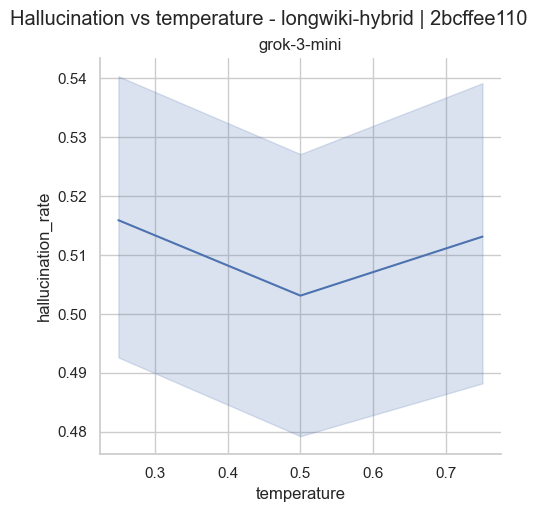

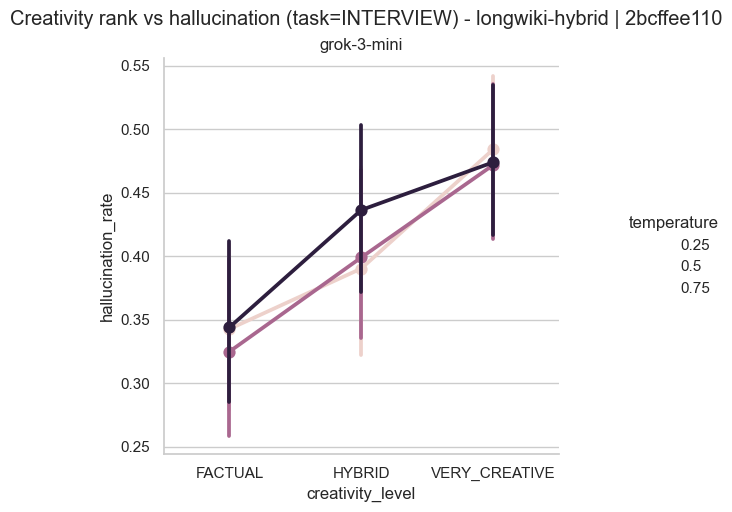

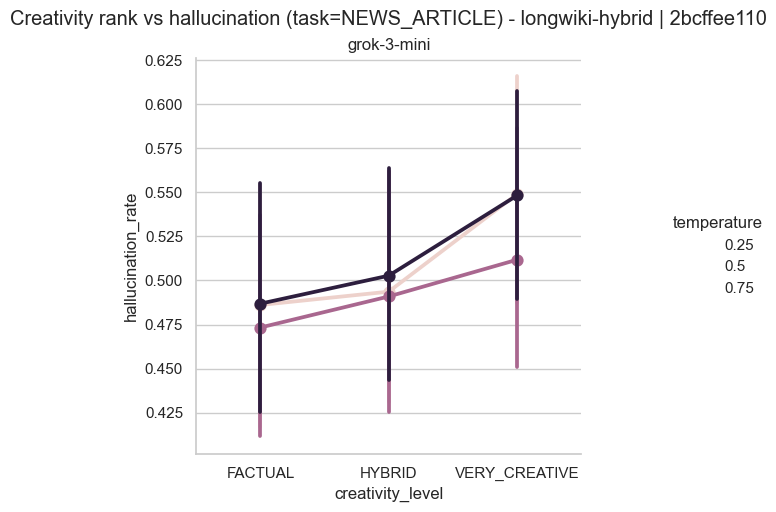

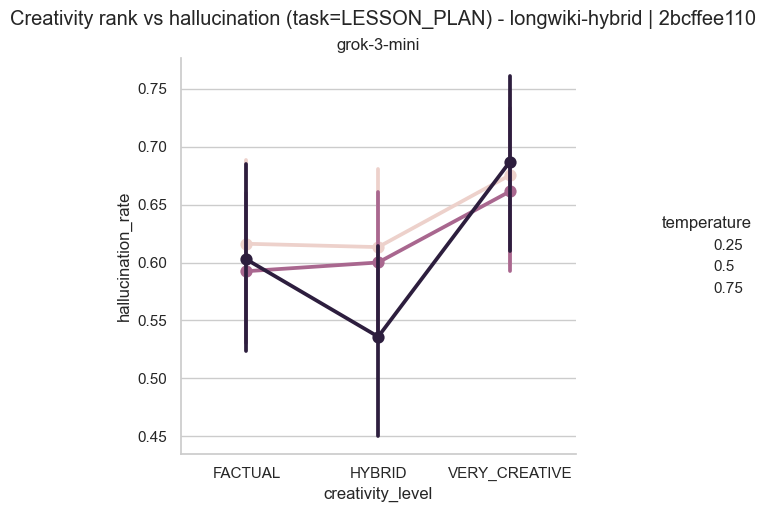

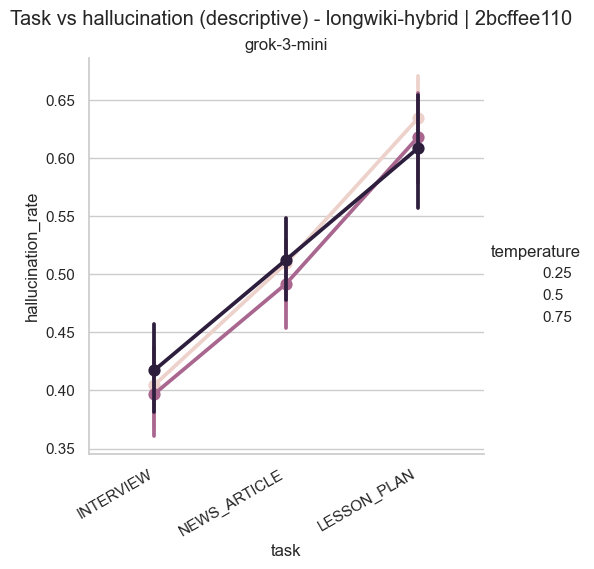

In [ ]:
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip analysis A.')
else:
    df_metrics = df_prompts[df_prompts['metrics_available']].copy()

    CREATIVITY_ORDER = ['FACTUAL', 'HYBRID', 'VERY_CREATIVE']

    group_keys = (
        df_metrics[['root', 'prompt_set_id']]
        .dropna()
        .drop_duplicates()
        .sort_values(['root', 'prompt_set_id'])
        .itertuples(index=False, name=None)
    )

    for root, prompt_set_id in group_keys:
        root_name = Path(str(root)).name
        df_group = df_metrics[(df_metrics['root'] == root) & (df_metrics['prompt_set_id'] == prompt_set_id)]
        df_runs_group = df_runs_filtered[(df_runs_filtered['root'] == root) & (df_runs_filtered['prompt_set_id'] == prompt_set_id)]

        if df_group.empty:
            continue

        group_label = f"{root_name} | {prompt_set_id[:10]}"

        print('' + '=' * 120)
        print(
            f"Root: {root_name} | Prompt set: {prompt_set_id} | "
            f"runs: {df_runs_group['run_id'].nunique()} | prompts: {df_group['prompt_id'].nunique()}"
        )

        # Run summary
        display(
            df_runs_group[[
                'run_id', 'model_name', 'temperature', 'length_words', 'tasks',
                'n_prompts', 'has_output_csv', 'has_generation'
            ]].sort_values(['model_name', 'length_words', 'temperature', 'run_id'])
        )

        # Availability grid
        grid = availability_grid(df_runs_group)
        if not grid.empty:
            print('Availability grid (model x length x temperature):')
            display(grid.sort_values(['model_name', 'length_words', 'temperature']))

        # Collapse replicate runs: one row per (condition, prompt_id)
        df_prompt_unit = (
            df_group
            .groupby(['model_name', 'temperature', 'length_words', 'prompt_id'], as_index=False)
            .agg(
                hallucination_rate=('hallucination_rate', 'mean'),
                task=('task', 'first'),
                creativity_level=('creativity_level', 'first'),
            )
        )

        # Ordered categories for readability
        if df_prompt_unit['creativity_level'].notna().any():
            present = df_prompt_unit['creativity_level'].dropna().unique().tolist()
            if set(present).issubset(set(CREATIVITY_ORDER)):
                df_prompt_unit['creativity_level'] = pd.Categorical(
                    df_prompt_unit['creativity_level'],
                    categories=CREATIVITY_ORDER,
                    ordered=True,
                )

        # Condition-level prompt means for paired comparisons
        cond_cols = ['model_name', 'temperature', 'length_words']
        df_cond = condition_prompt_means(df_group, cond_cols, id_col='prompt_id')

        # Temperature effect within model & length
        print('Temperature effect (paired by prompt_id):')
        for (model_name, length_words), sub in df_cond.groupby(['model_name', 'length_words']):
            temps = sorted([t for t in sub['temperature'].dropna().unique()])
            if len(temps) < 2:
                continue
            for t_a, t_b in itertools.combinations(temps, 2):
                df_a = sub[sub['temperature'] == t_a]
                df_b = sub[sub['temperature'] == t_b]
                merged, diffs = paired_diffs(df_a, df_b, id_col='prompt_id')
                stats = summarize_diffs(diffs)
                result = {
                    'comparison_type': 'temperature',
                    'root': root_name,
                    'prompt_set_id': prompt_set_id,
                    'model_name': model_name,
                    'length_words': length_words,
                    'temperature_a': t_a,
                    'temperature_b': t_b,
                    **stats,
                }
                add_comparison(result)
                print(result)

        # Model effect within temperature & length
        print('Model effect (paired by prompt_id):')
        for (temperature, length_words), sub in df_cond.groupby(['temperature', 'length_words']):
            models = sorted([m for m in sub['model_name'].dropna().unique()])
            if len(models) < 2:
                continue
            for m_a, m_b in itertools.combinations(models, 2):
                df_a = sub[sub['model_name'] == m_a]
                df_b = sub[sub['model_name'] == m_b]
                merged, diffs = paired_diffs(df_a, df_b, id_col='prompt_id')
                stats = summarize_diffs(diffs)
                result = {
                    'comparison_type': 'model',
                    'root': root_name,
                    'prompt_set_id': prompt_set_id,
                    'temperature': temperature,
                    'length_words': length_words,
                    'model_a': m_a,
                    'model_b': m_b,
                    **stats,
                }
                add_comparison(result)
                print(result)

        # Plots
        if HAVE_SNS:
            # 1) Hallucination vs temperature
            g = sns.relplot(
                data=df_prompt_unit,
                x='temperature',
                y='hallucination_rate',
                col='model_name',
                kind='line',
                estimator='mean',
                errorbar=('ci', 95),
                facet_kws={'sharey': True, 'sharex': True},
            )
            g.set_titles(col_template='{col_name}')
            g.fig.suptitle(f"Hallucination vs temperature - {group_label}", y=1.02)
            plt.show()

            # 2) Creativity vs hallucination (descriptive) - one plot per task
            if df_prompt_unit['creativity_level'].notna().any() and df_prompt_unit['task'].notna().any():
                temps = sorted(df_prompt_unit['temperature'].dropna().unique())
                task_list = [t for t in TASKS_FOCUS if t in df_prompt_unit['task'].unique().tolist()]
                other_tasks = [t for t in sorted(df_prompt_unit['task'].dropna().unique()) if t not in task_list]
                task_list = task_list + other_tasks

                for task_name in task_list:
                    df_task = df_prompt_unit[df_prompt_unit['task'] == task_name].dropna(subset=['creativity_level'])
                    if df_task.empty:
                        continue

                    g = sns.catplot(
                        data=df_task,
                        x='creativity_level',
                        y='hallucination_rate',
                        hue='temperature',
                        col='model_name',
                        kind='point',
                        estimator='mean',
                        errorbar=('ci', 95),
                        order=CREATIVITY_ORDER,
                        hue_order=temps,
                        sharey=True,
                    )
                    g.set_titles(col_template='{col_name}')
                    g.fig.suptitle(
                        f"Creativity rank vs hallucination (task={task_name}) - {group_label}",
                        y=1.02,
                    )
                    plt.show()


            # 3) Task vs hallucination (descriptive)
            if df_prompt_unit['task'].notna().any() and df_prompt_unit['task'].nunique() <= 12:
                temps = sorted(df_prompt_unit['temperature'].dropna().unique())
                task_order = [t for t in TASKS_FOCUS if t in df_prompt_unit['task'].unique().tolist()]
                other_tasks = [t for t in sorted(df_prompt_unit['task'].dropna().unique()) if t not in task_order]
                task_order = task_order + other_tasks

                g = sns.catplot(
                    data=df_prompt_unit.dropna(subset=['task']),
                    x='task',
                    y='hallucination_rate',
                    hue='temperature',
                    col='model_name',
                    kind='point',
                    estimator='mean',
                    errorbar=('ci', 95),
                    order=task_order,
                    hue_order=temps,
                    sharey=True,
                )
                g.set_titles(col_template='{col_name}')
                g.set_xticklabels(rotation=30, ha='right')
                g.fig.suptitle(
                    f"Task vs hallucination (descriptive) - {group_label}",
                    y=1.02,
                )
                plt.show()
        else:
            print('Seaborn unavailable - skipping plots.')


## 6) Analyses LENGTH par instance_set_id (instances identiques, prompts differents)


Root: longwiki-hybrid | Instance set: 1d83077de4766b1030ef5a379f5582cae80088989edf976371c0c707af734893 | runs: 3 | instances: 448


,run_id,model_name,temperature,length_words,tasks,n_prompts,has_output_csv,has_generation
0,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.25,50,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True
1,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.50,50,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True
2,longwiki-hybrid/grok-3-mini__static_prompts_ta...,grok-3-mini,0.75,50,"[INTERVIEW, NEWS_ARTICLE, LESSON_PLAN]",450,True,True


Length effect (paired by instance_id):


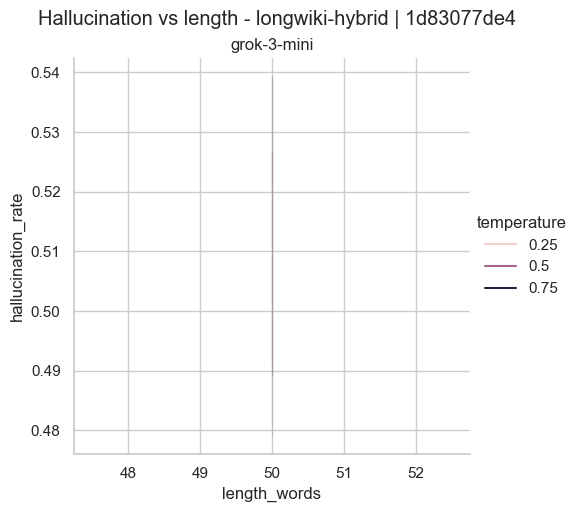

In [ ]:
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip analysis B.')
else:
    df_metrics = df_prompts[df_prompts['metrics_available']].copy()

    # Filter out rows with missing instance_id
    df_metrics = df_metrics[df_metrics['instance_id'].notna()]

    group_keys = (
        df_metrics[['root', 'instance_set_id']]
        .dropna()
        .drop_duplicates()
        .sort_values(['root', 'instance_set_id'])
        .itertuples(index=False, name=None)
    )

    for root, instance_set_id in group_keys:
        root_name = Path(str(root)).name
        df_group = df_metrics[(df_metrics['root'] == root) & (df_metrics['instance_set_id'] == instance_set_id)]
        df_runs_group = df_runs_filtered[(df_runs_filtered['root'] == root) & (df_runs_filtered['instance_set_id'] == instance_set_id)]

        if df_group.empty:
            continue

        group_label = f"{root_name} | {instance_set_id[:10]}"

        print('' + '=' * 120)
        print(
            f"Root: {root_name} | Instance set: {instance_set_id} | "
            f"runs: {df_runs_group['run_id'].nunique()} | instances: {df_group['instance_id'].nunique()}"
        )

        display(
            df_runs_group[[
                'run_id', 'model_name', 'temperature', 'length_words', 'tasks',
                'n_prompts', 'has_output_csv', 'has_generation'
            ]].sort_values(['model_name', 'length_words', 'temperature', 'run_id'])
        )

        # Collapse replicate runs: one row per (condition, instance_id)
        df_instance_unit = (
            df_group
            .groupby(['model_name', 'temperature', 'length_words', 'instance_id'], as_index=False)
            .agg(
                hallucination_rate=('hallucination_rate', 'mean'),
                task=('task', 'first'),
                creativity_level=('creativity_level', 'first'),
            )
        )

        # Length effect within model & temperature
        print('Length effect (paired by instance_id):')
        for (model_name, temperature), sub in df_instance_unit.groupby(['model_name', 'temperature']):
            lengths = sorted([l for l in sub['length_words'].dropna().unique()])
            if len(lengths) < 2:
                continue
            for l_a, l_b in itertools.combinations(lengths, 2):
                df_a = sub[sub['length_words'] == l_a]
                df_b = sub[sub['length_words'] == l_b]
                merged, diffs = paired_diffs(df_a, df_b, id_col='instance_id')
                stats = summarize_diffs(diffs)
                result = {
                    'comparison_type': 'length',
                    'root': root_name,
                    'instance_set_id': instance_set_id,
                    'model_name': model_name,
                    'temperature': temperature,
                    'length_a': l_a,
                    'length_b': l_b,
                    **stats,
                }
                add_comparison(result)
                print(result)

        # Plot
        if HAVE_SNS:
            g = sns.relplot(
                data=df_instance_unit,
                x='length_words',
                y='hallucination_rate',
                col='model_name',
                hue='temperature',
                kind='line',
                estimator='mean',
                errorbar=('ci', 95),
                facet_kws={'sharey': True, 'sharex': True},
            )
            g.set_titles(col_template='{col_name}')
            g.fig.suptitle(f"Hallucination vs length - {group_label}", y=1.02)
            plt.show()
        else:
            print('Seaborn unavailable - skipping plots.')


In [ ]:
# ---- Plotly: distributions interactives ----
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, HTML

# Base pour plots
df_plot = df_prompts[df_prompts['metrics_available']].copy()

# Normaliser pour affichage (categories)
df_plot['length_words_str'] = df_plot['length_words'].astype('Int64').astype(str)
df_plot['temperature_str'] = df_plot['temperature'].astype(str)
df_plot['creativity_rank'] = df_plot['creativity_level'].map({'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2})

# Helpers pour ordre numerique

def fmt_len(v):
    try:
        fv = float(v)
        if fv.is_integer():
            return str(int(fv))
        return str(fv)
    except Exception:
        return str(v)

# Listes de filtres
models = ['ALL'] + sorted(df_plot['model_name'].dropna().unique().tolist())
tasks = ['ALL'] + sorted(df_plot['task'].dropna().unique().tolist())
temps = ['ALL'] + [str(v) for v in sorted(df_plot['temperature'].dropna().unique())]
lengths = ['ALL'] + [fmt_len(v) for v in sorted(df_plot['length_words'].dropna().unique())]
crea = ['ALL'] + ['FACTUAL', 'HYBRID', 'VERY_CREATIVE']

# Parametre X a analyser
x_param_options = {
    'Length words': 'length_words_str',
    'Temperature': 'temperature_str',
    'Creativity rank': 'creativity_level',
    'Task': 'task',
}

# Widgets
w_model = widgets.Dropdown(options=models, value='ALL', description='Model:')
w_task = widgets.Dropdown(options=tasks, value='ALL', description='Task:')
w_temp = widgets.Dropdown(options=temps, value='ALL', description='Temp:')
w_len = widgets.Dropdown(options=lengths, value='ALL', description='Length:')
w_crea = widgets.Dropdown(options=crea, value='ALL', description='Creativity:')
w_xparam = widgets.Dropdown(options=list(x_param_options.keys()), value='Creativity rank', description='X:')


def filter_df(df, model, task, temp, length, creativity):
    d = df.copy()
    if model != 'ALL':
        d = d[d['model_name'] == model]
    if task != 'ALL':
        d = d[d['task'] == task]
    if temp != 'ALL':
        d = d[d['temperature_str'] == temp]
    if length != 'ALL':
        d = d[d['length_words_str'] == length]
    if creativity != 'ALL':
        d = d[d['creativity_level'] == creativity]
    return d


def make_plot(model, task, temp, length, creativity, x_param_label):
    d = filter_df(df_plot, model, task, temp, length, creativity)
    if d.empty:
        print('Aucune donnee pour ces filtres.')
        return

    x_col = x_param_options[x_param_label]

    # Ordres categorie (length toujours croissante)
    temp_order = [str(v) for v in sorted(d['temperature'].dropna().unique())]
    length_order = [fmt_len(v) for v in sorted(d['length_words'].dropna().unique())]

    # Violin plot (distribution + box + points)
    fig = px.violin(
        d,
        x=x_col,
        y='hallucination_rate',
        color='temperature_str',
        box=True,
        points='all',
        hover_data=['model_name', 'task', 'length_words', 'temperature', 'creativity_level', 'title'],
        facet_col=None if model != 'ALL' else 'model_name',
        category_orders={
            'creativity_level': ['FACTUAL', 'HYBRID', 'VERY_CREATIVE'],
            'temperature_str': temp_order,
            'length_words_str': length_order,
        }
    )
    fig.update_layout(
        title=f"Distribution hallucination_rate vs {x_param_label}",
        xaxis_title=x_param_label,
        yaxis_title='Hallucination rate',
        violinmode='group',
        height=450
    )
    fig.show()

    # Afficher le nombre de prompts sous le graphique (apres filtres)
    n_prompts = d['title'].dropna().nunique()
    display(HTML(f"<div style='margin-top:8px'><b>Prompts:</b> {n_prompts}</div>"))


ui = widgets.VBox([
    widgets.HBox([w_model, w_task]),
    widgets.HBox([w_temp, w_len, w_crea]),
    w_xparam
])

out = widgets.interactive_output(
    make_plot,
    {
        'model': w_model,
        'task': w_task,
        'temp': w_temp,
        'length': w_len,
        'creativity': w_crea,
        'x_param_label': w_xparam
    }
)

display(ui, out)


Output()

## 7) Creativite & Tache - detecter si le design permet une analyse appariee


In [ ]:
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip creativity/task analysis.')
else:
    df_metrics = df_prompts[df_prompts['metrics_available']].copy()

    def can_within_title_creativity(df):
        required = ['title', 'task', 'length_words', 'model_name', 'temperature', 'creativity_level']
        if not all(c in df.columns for c in required):
            return False
        return df.groupby(['title', 'task', 'length_words', 'model_name', 'temperature'])['creativity_level'].nunique().max() > 1

    def can_within_title_task(df):
        required = ['title', 'creativity_level', 'length_words', 'model_name', 'temperature', 'task']
        if not all(c in df.columns for c in required):
            return False
        return df.groupby(['title', 'creativity_level', 'length_words', 'model_name', 'temperature'])['task'].nunique().max() > 1

    def paired_factor_effect(df, factor_col, match_cols):
        results = []
        for _, sub in df.groupby(match_cols):
            levels = sorted(sub[factor_col].dropna().unique())
            if len(levels) < 2:
                continue
            # average per level within this match group
            level_means = sub.groupby(factor_col)['hallucination_rate'].mean().to_dict()
            for a, b in itertools.combinations(levels, 2):
                if a in level_means and b in level_means:
                    results.append(level_means[b] - level_means[a])
        return np.asarray(results, dtype=float)

    # Creativity
    if can_within_title_creativity(df_metrics):
        diffs = paired_factor_effect(
            df_metrics,
            factor_col='creativity_level',
            match_cols=['title', 'task', 'length_words', 'model_name', 'temperature'],
        )
        stats = summarize_diffs(diffs)
        print('Creativity paired effect (within-title):')
        print(stats)
    else:
        print('Creativity analysis: design does NOT support within-title pairing. Showing descriptive stats only (confounded by topics).')
        display(
            df_metrics.groupby(['model_name', 'creativity_level'])['hallucination_rate']
            .mean()
            .reset_index()
            .sort_values(['model_name', 'hallucination_rate'])
        )

    # Task
    if can_within_title_task(df_metrics):
        diffs = paired_factor_effect(
            df_metrics,
            factor_col='task',
            match_cols=['title', 'creativity_level', 'length_words', 'model_name', 'temperature'],
        )
        stats = summarize_diffs(diffs)
        print('Task paired effect (within-title):')
        print(stats)
    else:
        print('Task analysis: design does NOT support within-title pairing. Showing descriptive stats only (confounded by topics).')
        display(
            df_metrics.groupby(['model_name', 'task'])['hallucination_rate']
            .mean()
            .reset_index()
            .sort_values(['model_name', 'hallucination_rate'])
        )


Creativity paired effect (within-title):
{'n_paired': 1316, 'mean_diff': 0.0646926760671322, 'median_diff': 0.06388888888888888, 'ci_low': 0.053133801741137195, 'ci_high': 0.07583607380995634}
Task paired effect (within-title):
{'n_paired': 1314, 'mean_diff': 0.06066504970214493, 'median_diff': 0.06607142857142856, 'ci_low': 0.04614439042799934, 'ci_high': 0.07506652452043827}


In [ ]:
# Correlation avec hallucination (delta vs baseline FACTUAL & T=0) par dataset
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

TASKS_FOCUS = ['INTERVIEW', 'NEWS_ARTICLE', 'LESSON_PLAN']
CREATIVITY_RANK = {'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2}
BASELINE_CREATIVE = 'FACTUAL'
BASELINE_TEMP = 0.0

# df_base doit contenir: root, hallucination_rate, length_words, temperature, creativity_level, task
# Exemple si tu utilises df_prompts:
df_base = df_prompts[df_prompts['metrics_available']].copy()

df_corr = df_base.copy()
df_corr['root_name'] = df_corr['root'].apply(lambda x: Path(str(x)).name)

for root_name, df_root in df_corr.groupby('root_name'):
    # Filtre tasks focus
    df_root = df_root[df_root['task'].isin(TASKS_FOCUS)].copy()
    if df_root.empty:
        print(f"[SKIP] {root_name}: aucune task dans TASKS_FOCUS")
        continue

    # Baseline FACTUAL + T=0
    df_ref = df_root[
        (df_root['creativity_level'] == BASELINE_CREATIVE) &
        (df_root['temperature'] == BASELINE_TEMP)
    ]
    if df_ref.empty:
        print(f"[SKIP] {root_name}: baseline FACTUAL@T0 absente")
        continue

    baseline = df_ref['hallucination_rate'].mean()
    df_root['delta_h'] = df_root['hallucination_rate'] - baseline

    # Encodage creativity
    df_root['creativity_rank'] = df_root['creativity_level'].map(CREATIVITY_RANK)

    # One-hot tasks
    task_dummies = pd.get_dummies(df_root['task'], prefix='task')

    corr_df = pd.concat([
        df_root[['delta_h', 'length_words', 'temperature', 'creativity_rank']],
        task_dummies
    ], axis=1)

    corr = (
        corr_df
        .corr(method='pearson')['delta_h']
        .drop('delta_h')
    )

    # Ordonner les facteurs principaux (et garder les tasks apres)
    ordered = ['creativity_rank', 'length_words', 'temperature']
    corr = corr.reindex([c for c in ordered if c in corr.index] + [c for c in corr.index if c not in ordered])

    # Graphique
    plt.figure(figsize=(7, 4))
    sns.barplot(x=corr.values, y=corr.index, orient='h', palette='viridis')
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f"{root_name} - Corr(Pearson) vs delta hallucination\n(baseline: FACTUAL, T=0)")
    plt.xlabel('Correlation')
    plt.ylabel('Parametre')
    plt.tight_layout()
    plt.show()


[SKIP] longwiki-hybrid: baseline FACTUAL@T0 absente


## 8) Correlations creativite <-> hallucination (robustes)

Ce bloc :
- agrege au niveau prompt_id pour eviter la pseudo-replication
- calcule Spearman/Pearson, IC95% (bootstrap / Fisher)
- p-values via permutation (recommande si n modeste)
- corrige la longueur (partial corr)
- applique FDR BH sur toutes les p-values


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

try:
    from statsmodels.stats.multitest import multipletests
except Exception as e:
    multipletests = None
    print('statsmodels not available -> fallback FDR BH', e)

try:
    import pingouin as pg
except Exception as e:
    pg = None
    print('pingouin not available -> fallback partial corr', e)


def _get_stat_value(res):
    return float(res.statistic) if hasattr(res, 'statistic') else float(res[0])


def _get_p_value(res):
    return float(res.pvalue) if hasattr(res, 'pvalue') else float(res[1])


def _pick_length_col(df):
    for c in ('length_tokens', 'length_words', 'length_chars'):
        if c in df.columns:
            return c
    return None


def _fdr_bh(pvals):
    p = np.asarray(pvals, dtype=float)
    n = len(p)
    order = np.argsort(p)
    ranked = p[order]
    q = ranked * n / (np.arange(1, n + 1))
    q = np.minimum.accumulate(q[::-1])[::-1]
    p_adj = np.empty_like(q)
    p_adj[order] = np.clip(q, 0, 1)
    return p_adj


# -----------------------------
# 0) Pre-aggregation (important)
# -----------------------------

def aggregate_to_item_level(df: pd.DataFrame, group_cols) -> pd.DataFrame:
    """
    If you have k samples / item / condition, avoid pseudo-replication:
    -> aggregate to (prompt_id + condition) before correlating.
    """
    metric_cols = [
        c for c in (
            'creativity_rank', 'temperature',
            'hallucination_rate', 'support_rate', 'n_claims'
        ) if c in df.columns and c not in group_cols
    ]

    df2 = (
        df[group_cols + metric_cols]
        .groupby(group_cols, dropna=False)
        .mean(numeric_only=True)
        .reset_index()
    )
    return df2


# -----------------------------
# 1) CI bootstrap (generic)
# -----------------------------

def bootstrap_ci_corr(x: np.ndarray, y: np.ndarray, method: str, n_boot=2000, seed=0):
    """
    95% CI via bootstrap:
    - resample pairs (x_i, y_i) with replacement
    - recompute correlation at each bootstrap
    """
    rng = np.random.default_rng(seed)
    n = len(x)
    stats_boot = []

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        xb, yb = x[idx], y[idx]
        if method == 'spearman':
            r = _get_stat_value(stats.spearmanr(xb, yb))
        elif method == 'pearson':
            r = _get_stat_value(stats.pearsonr(xb, yb))
        else:
            raise ValueError("method must be 'spearman' or 'pearson'")
        if np.isfinite(r):
            stats_boot.append(r)

    if not stats_boot:
        return (np.nan, np.nan)
    lo, hi = np.quantile(stats_boot, [0.025, 0.975])
    return float(lo), float(hi)


# -----------------------------------------
# 2) p-value permutation (correlation)
# -----------------------------------------


def permutation_pvalue_corr(x: np.ndarray, y: np.ndarray, method: str, n_resamples=5000, seed=0):
    """
    Monte Carlo permutation test (avoids SciPy overflow warnings).
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if method == 'spearman':
        x_use = stats.rankdata(x)
        y_use = stats.rankdata(y)
    elif method == 'pearson':
        x_use = x
        y_use = y
    else:
        raise ValueError

    x_use = x_use - x_use.mean()
    y_use = y_use - y_use.mean()
    denom = np.sqrt(np.sum(x_use ** 2) * np.sum(y_use ** 2))
    if denom == 0 or not np.isfinite(denom):
        return np.nan

    obs = float(np.dot(x_use, y_use) / denom)
    count = 0
    for _ in range(n_resamples):
        xp = rng.permutation(x_use)
        r = float(np.dot(xp, y_use) / denom)
        if abs(r) >= abs(obs):
            count += 1

    return (count + 1) / (n_resamples + 1)


# -----------------------------------------
# 3) Correlation + CI + p-value
# -----------------------------------------

def _fisher_ci(r, n, alpha=0.05):
    if n <= 3 or not np.isfinite(r):
        return (np.nan, np.nan)
    r = float(np.clip(r, -0.999999, 0.999999))
    z = np.arctanh(r)
    se = 1.0 / np.sqrt(n - 3)
    zcrit = stats.norm.ppf(1 - alpha / 2)
    lo = np.tanh(z - zcrit * se)
    hi = np.tanh(z + zcrit * se)
    return float(lo), float(hi)


def corr_with_inference(df: pd.DataFrame, x_col: str, y_col: str, method='spearman',
                        ci_mode='bootstrap', n_boot=2000, n_perm=10000, seed=0, perm_if_n_lt=500):
    sub = df[[x_col, y_col]].dropna()
    x = sub[x_col].to_numpy()
    y = sub[y_col].to_numpy()
    n = len(x)
    if n < 4:
        return {'n': n, 'r': np.nan, 'p': np.nan, 'ci_low': np.nan, 'ci_high': np.nan}

    if method == 'spearman':
        res = stats.spearmanr(x, y)
        r = _get_stat_value(res)
        if n < perm_if_n_lt:
            p = permutation_pvalue_corr(x, y, method='spearman', n_resamples=n_perm, seed=seed)
        else:
            p = _get_p_value(res)
        ci_low, ci_high = bootstrap_ci_corr(x, y, method='spearman', n_boot=n_boot, seed=seed)

    elif method == 'pearson':
        res = stats.pearsonr(x, y)
        r = _get_stat_value(res)
        p = _get_p_value(res)
        if hasattr(res, 'confidence_interval'):
            ci = res.confidence_interval(confidence_level=0.95)
            ci_low, ci_high = float(ci.low), float(ci.high)
        else:
            ci_low, ci_high = _fisher_ci(r, n)

    else:
        raise ValueError("method must be 'spearman' or 'pearson'")

    return {
        'n': n,
        'r': float(r),
        'p': float(p),
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
        'r2': float(r * r),
    }


# -----------------------------------------
# 4) Partial correlation (control length)
# -----------------------------------------

def _residualize(y, z):
    z = np.asarray(z, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(np.unique(z[~np.isnan(z)])) < 2:
        return None
    A = np.column_stack([np.ones(len(z)), z])
    coef, *_ = np.linalg.lstsq(A, y, rcond=None)
    y_hat = A @ coef
    return y - y_hat


def partial_corr_length(df: pd.DataFrame, x_col: str, y_col: str, length_col: str,
                        method='spearman', n_boot=2000, seed=0):
    sub = df[[x_col, y_col, length_col]].dropna()
    if len(sub) < 4:
        return {'n': len(sub), 'r_partial': np.nan, 'p_partial': np.nan, 'ci_low': np.nan, 'ci_high': np.nan}

    if pg is not None:
        try:
            out = pg.partial_corr(data=sub, x=x_col, y=y_col, covar=length_col, method=method)
            r = float(out['r'].iloc[0])
            p = float(out['p-val'].iloc[0])
            ci_low, ci_high = out['CI95'].iloc[0]
            return {
                'n': int(out['n'].iloc[0]),
                'r_partial': r,
                'p_partial': p,
                'ci_low': float(ci_low),
                'ci_high': float(ci_high),
            }
        except Exception:
            # fall back below
            pass

    # Fallback: residualize then Pearson on residuals
    if method == 'spearman':
        x = stats.rankdata(sub[x_col])
        y = stats.rankdata(sub[y_col])
        z = stats.rankdata(sub[length_col])
    else:
        x = sub[x_col].to_numpy()
        y = sub[y_col].to_numpy()
        z = sub[length_col].to_numpy()

    rx = _residualize(x, z)
    ry = _residualize(y, z)
    if rx is None or ry is None:
        return {'n': len(sub), 'r_partial': np.nan, 'p_partial': np.nan, 'ci_low': np.nan, 'ci_high': np.nan}

    res = stats.pearsonr(rx, ry)
    r = _get_stat_value(res)
    p = _get_p_value(res)
    ci_low, ci_high = bootstrap_ci_corr(rx, ry, method='pearson', n_boot=n_boot, seed=seed)

    return {
        'n': len(sub),
        'r_partial': float(r),
        'p_partial': float(p),
        'ci_low': float(ci_low),
        'ci_high': float(ci_high),
    }


# -----------------------------------------
# 5) Batch: all pairs + sub-groups
# -----------------------------------------

def run_correlation_suite(df: pd.DataFrame,
                          C_cols=('creativity_rank',),
                          H_cols=('hallucination_rate', 'support_rate', 'n_claims'),
                          group_cols=('root', 'task', 'model_name', 'temperature'),
                          length_col='length_words',
                          method='spearman',
                          min_n_partial=10,
                          n_boot=2000,
                          n_perm=10000,
                          seed=0,
                          perm_if_n_lt=500):
    results = []
    pvals_for_fdr = []

    # global
    for c in C_cols:
        for h in H_cols:
            base = corr_with_inference(df, c, h, method=method, n_boot=n_boot, n_perm=n_perm, seed=seed, perm_if_n_lt=perm_if_n_lt)
            pc = partial_corr_length(df, c, h, length_col, method=method, n_boot=n_boot, seed=seed) if length_col in df.columns else {
                'n': base['n'], 'r_partial': np.nan, 'p_partial': np.nan, 'ci_low': np.nan, 'ci_high': np.nan
            }
            row = {'scope': 'global', 'group_key': 'ALL', 'x': c, 'y': h, **base, **pc}
            results.append(row)
            pvals_for_fdr.append(row['p'])

    # by groups
    for keys, g in df.groupby(list(group_cols), dropna=False):
        group_key = '|'.join(map(str, keys))
        for c in C_cols:
            for h in H_cols:
                base = corr_with_inference(g, c, h, method=method, n_boot=n_boot, n_perm=n_perm, seed=seed, perm_if_n_lt=perm_if_n_lt)
                if base['n'] >= min_n_partial and length_col in g.columns:
                    pc = partial_corr_length(g, c, h, length_col, method=method, n_boot=n_boot, seed=seed)
                else:
                    pc = {'n': base['n'], 'r_partial': np.nan, 'p_partial': np.nan, 'ci_low': np.nan, 'ci_high': np.nan}
                row = {'scope': 'group', 'group_key': group_key, 'x': c, 'y': h, **base, **pc}
                results.append(row)
                pvals_for_fdr.append(row['p'])

    res_df = pd.DataFrame(results)

    # -----------------------------------------
    # 6) Multiple testing correction (FDR BH)
    # -----------------------------------------
    pvals = np.asarray(pvals_for_fdr, dtype=float)
    p_fdr = np.full_like(pvals, np.nan, dtype=float)
    mask = np.isfinite(pvals)
    if mask.any():
        if multipletests is not None:
            _, p_fdr[mask], _, _ = multipletests(pvals[mask], alpha=0.05, method='fdr_bh')
        else:
            p_fdr[mask] = _fdr_bh(pvals[mask])
    res_df['p_fdr_bh'] = p_fdr

    return res_df


# -----------------------------
# 7) Example usage (adapt columns)
# -----------------------------
if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip correlation suite')
else:
    df_corr = df_prompts[df_prompts['metrics_available']].copy()

    # Map creativity_level -> numeric rank
    if 'creativity_level' in df_corr.columns:
        creativity_rank = {'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2}
        df_corr['creativity_rank'] = df_corr['creativity_level'].map(creativity_rank)

    # Choose length column (tokens if available, else words)
    length_col = _pick_length_col(df_corr) or 'length_words'

    # Aggregate to item level (prompt_id + condition)
    group_cols = [
        c for c in (
            'prompt_id', 'prompt_set_id', 'instance_set_id',
            'root', 'task', 'model_name', 'temperature'
        ) if c in df_corr.columns
    ]
    df_item = aggregate_to_item_level(df_corr, group_cols=group_cols)

    # Define which columns to correlate
    C_cols = [c for c in ('creativity_rank',) if c in df_item.columns]
    H_cols = [c for c in ('hallucination_rate', 'support_rate', 'n_claims') if c in df_item.columns]
    group_cols = [c for c in ('root', 'task', 'model_name', 'temperature') if c in df_item.columns]

    
    CORR_N_BOOT = 1000
    CORR_N_PERM = 2000
    PERM_IF_N_LT = 500

    res_corr = run_correlation_suite(
        df_item,
        C_cols=C_cols,
        H_cols=H_cols,
        group_cols=group_cols,
        length_col=length_col,
        method='spearman',
        n_boot=CORR_N_BOOT,
        n_perm=CORR_N_PERM,
        seed=7,
        perm_if_n_lt=PERM_IF_N_LT,
    )

    display(res_corr.head(20))

    # Optional export
    # res_corr.to_csv(ARTIFACTS_DIR / 'corr_creativity_hallucination.csv', index=False)


,scope,group_key,x,y,n,r,p,ci_low,ci_high,r2,r_partial,p_partial,p_fdr_bh
0,global,ALL,creativity_rank,hallucination_rate,1332,0.139189,3.396577e-07,NaN,NaN,0.019374,NaN,NaN,0.000005
1,global,ALL,creativity_rank,support_rate,1332,-0.139189,3.396577e-07,NaN,NaN,0.019374,NaN,NaN,0.000005
2,global,ALL,creativity_rank,n_claims,1332,0.039350,1.511868e-01,NaN,NaN,0.001548,NaN,NaN,0.237631
3,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,hallucination_rate,147,0.266704,1.499250e-03,NaN,NaN,0.071131,NaN,NaN,0.007496
4,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,support_rate,147,-0.266704,1.499250e-03,NaN,NaN,0.071131,NaN,NaN,0.007496
5,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,n_claims,147,0.115987,1.584208e-01,NaN,NaN,0.013453,NaN,NaN,0.237631
6,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,hallucination_rate,147,0.276186,9.995002e-04,NaN,NaN,0.076279,NaN,NaN,0.007496
7,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,support_rate,147,-0.276186,9.995002e-04,NaN,NaN,0.076279,NaN,NaN,0.007496
8,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,n_claims,147,0.057243,4.882559e-01,NaN,NaN,0.003277,NaN,NaN,0.523131
9,group,../output/longwiki-hybrid|INTERVIEW|grok-3-min...,creativity_rank,hallucination_rate,146,0.235639,3.498251e-03,NaN,NaN,0.055526,NaN,NaN,0.013118


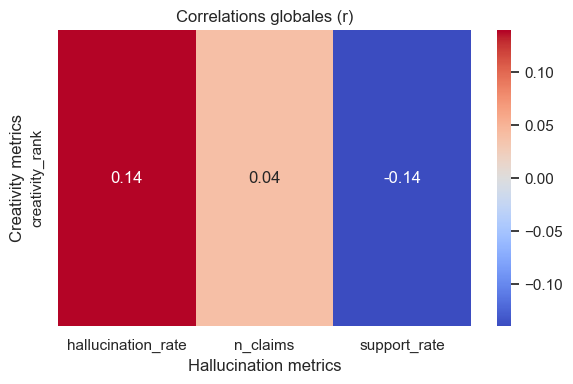

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'res_corr' not in globals() or res_corr is None or res_corr.empty:
    print('res_corr empty - skip correlation plot')
else:
    df_viz = res_corr[res_corr['scope'] == 'global'].copy()
    if df_viz.empty:
        print('No global correlations to plot')
    else:
        pivot = df_viz.pivot(index='x', columns='y', values='r')
        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm', center=0)
        plt.title('Correlations globales (r)')
        plt.xlabel('Hallucination metrics')
        plt.ylabel('Creativity metrics')
        plt.tight_layout()
        plt.show()


/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_59771/3838846615.py:107: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_59771/3838846615.py:107: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_59771/3838846615.py:107: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/f1/1qn2tdrs1fb_jpky6b0pyk9m0000gn/T/ipykernel_59771/3838846615.py:107: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Ass

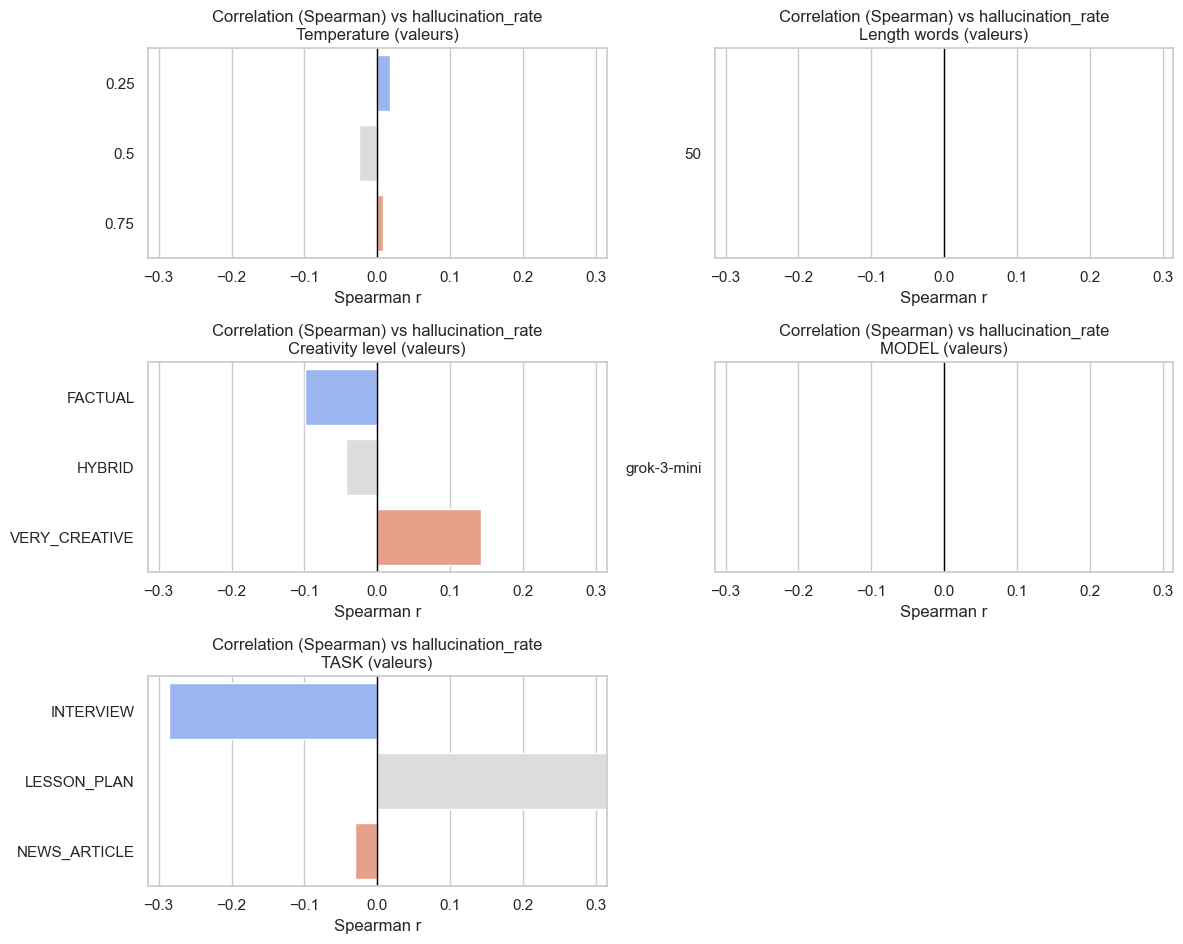

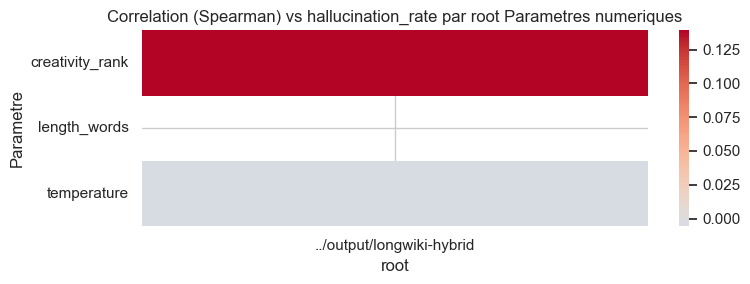

/opt/anaconda3/envs/hvsC/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning:

All-NaN slice encountered

/opt/anaconda3/envs/hvsC/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning:

All-NaN slice encountered



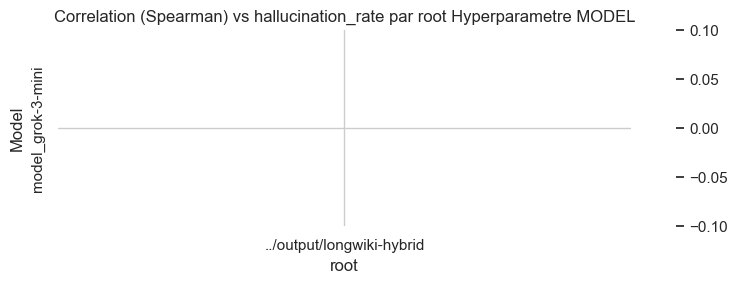

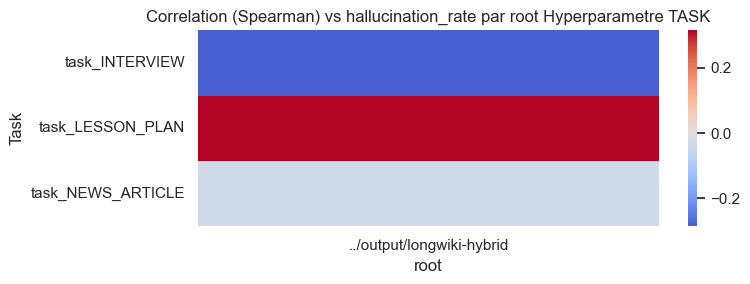

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_prompts' not in globals() or df_prompts.empty:
    print('df_prompts empty - skip parameter comparison')
else:
    df_cmp = df_prompts[df_prompts['metrics_available']].copy()

    if 'creativity_level' in df_cmp.columns:
        creativity_rank = {'FACTUAL': 0, 'HYBRID': 1, 'VERY_CREATIVE': 2}
        df_cmp['creativity_rank'] = df_cmp['creativity_level'].map(creativity_rank)

    base_cols = ['hallucination_rate']
    for c in ('temperature', 'length_words', 'creativity_rank', 'creativity_level'):
        if c in df_cmp.columns:
            base_cols.append(c)

    base = df_cmp[base_cols + [c for c in ('model_name', 'task', 'root') if c in df_cmp.columns]].copy()

    
    # --- Correlation barplots grouped in a single figure (all hyperparameters)
    def _corr_dummy(sub_df, col, prefix, order_levels=None, numeric_order=False):
        sub = sub_df[['hallucination_rate', col]].dropna()
        if sub.empty:
            return None
        dummies = pd.get_dummies(sub[col], prefix=prefix)
        corr = pd.concat([sub[['hallucination_rate']], dummies], axis=1).corr(method='spearman')['hallucination_rate']
        corr = corr.drop('hallucination_rate')

        if order_levels:
            order = [f"{prefix}_{lvl}" for lvl in order_levels if f"{prefix}_{lvl}" in corr.index]
            rest = [i for i in corr.index if i not in order]
            corr = corr.reindex(order + rest)
        elif numeric_order:
            def _key(name):
                val = name[len(prefix) + 1:]
                try:
                    f = float(val)
                    return (0, f)
                except Exception:
                    return (1, val)
            corr = corr.reindex(sorted(corr.index, key=_key))
        return corr

    plots = []

    # Treat numeric hyperparams as categorical levels (multiple values)
    if 'temperature' in base.columns:
        plots.append((
            'Temperature (valeurs)',
            _corr_dummy(base, 'temperature', 'temperature', numeric_order=True)
        ))
    if 'length_words' in base.columns:
        plots.append((
            'Length words (valeurs)',
            _corr_dummy(base, 'length_words', 'length', numeric_order=True)
        ))
    if 'creativity_level' in base.columns:
        plots.append((
            'Creativity level (valeurs)',
            _corr_dummy(base, 'creativity_level', 'creativity', order_levels=['FACTUAL', 'HYBRID', 'VERY_CREATIVE'])
        ))
    elif 'creativity_rank' in base.columns:
        plots.append((
            'Creativity rank (valeurs)',
            _corr_dummy(base, 'creativity_rank', 'creativity_rank', numeric_order=True)
        ))

    # Categorical hyperparameters
    if 'model_name' in base.columns:
        plots.append((
            'MODEL (valeurs)',
            _corr_dummy(base, 'model_name', 'model')
        ))
    if 'task' in base.columns:
        plots.append((
            'TASK (valeurs)',
            _corr_dummy(base, 'task', 'task')
        ))

    plots = [(title, corr) for title, corr in plots if corr is not None and len(corr) > 0]

    if plots:
        n_plots = len(plots)
        ncols = 2 if n_plots > 1 else 1
        nrows = (n_plots + ncols - 1) // ncols

        # shared x-limits
        max_abs = max(float(abs(c).max()) for _, c in plots)
        max_abs = max_abs if max_abs > 0 else 0.1

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3.2 * nrows))
        if nrows == 1 and ncols == 1:
            axes = [axes]
        elif nrows == 1:
            axes = list(axes)
        else:
            axes = [ax for row in axes for ax in row]

        for ax, (title, corr) in zip(axes, plots):
            df_plot = corr.reset_index()
            df_plot.columns = ['param', 'r']
            # remove prefix for labels
            df_plot['label'] = df_plot['param'].apply(lambda s: s.split('_', 1)[1] if '_' in s else s)

            sns.barplot(x='r', y='label', data=df_plot, ax=ax, palette='coolwarm')
            ax.axvline(0, color='black', linewidth=1)
            ax.set_title(f'Correlation (Spearman) vs hallucination_rate\n{title}')
            ax.set_xlabel('Spearman r')
            ax.set_ylabel('')
            ax.set_xlim(-max_abs, max_abs)

        # Hide any unused axes
        for ax in axes[len(plots):]:
            ax.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print('No hyperparameter correlation plots available.')

    
    # Numeric params list (for optional per-root analysis)
    num_cols = [c for c in ('temperature', 'length_words', 'creativity_rank') if c in base.columns]

# Optional: compare by dataset/root
    if 'root' in base.columns:
        # numeric by root
        if num_cols:
            rows = []
            for root, sub in base.groupby('root'):
                if sub['hallucination_rate'].notna().sum() < 5:
                    continue
                cnum = sub[['hallucination_rate'] + num_cols].corr(method='spearman')['hallucination_rate']
                cnum = cnum.drop('hallucination_rate')
                for k, v in cnum.items():
                    rows.append({'root': str(root), 'param': k, 'r': v})
            if rows:
                corr_root = pd.DataFrame(rows).pivot(index='param', columns='root', values='r')
                plt.figure(figsize=(8, max(3, 0.25 * len(corr_root))))
                sns.heatmap(corr_root, annot=False, cmap='coolwarm', center=0)
                plt.title('Correlation (Spearman) vs hallucination_rate par root Parametres numeriques')
                plt.xlabel('root')
                plt.ylabel('Parametre')
                plt.tight_layout()
                plt.show()

        # model by root
        if 'model_name' in base.columns:
            rows = []
            for root, sub in base.groupby('root'):
                if sub['hallucination_rate'].notna().sum() < 5:
                    continue
                d_model = pd.get_dummies(sub['model_name'], prefix='model')
                cmod = pd.concat([sub[['hallucination_rate']], d_model], axis=1).corr(method='spearman')['hallucination_rate']
                cmod = cmod.drop('hallucination_rate')
                for k, v in cmod.items():
                    rows.append({'root': str(root), 'param': k, 'r': v})
            if rows:
                corr_root = pd.DataFrame(rows).pivot(index='param', columns='root', values='r')
                plt.figure(figsize=(8, max(3, 0.25 * len(corr_root))))
                sns.heatmap(corr_root, annot=False, cmap='coolwarm', center=0)
                plt.title('Correlation (Spearman) vs hallucination_rate par root Hyperparametre MODEL')
                plt.xlabel('root')
                plt.ylabel('Model')
                plt.tight_layout()
                plt.show()

        # task by root
        if 'task' in base.columns:
            rows = []
            for root, sub in base.groupby('root'):
                if sub['hallucination_rate'].notna().sum() < 5:
                    continue
                d_task = pd.get_dummies(sub['task'], prefix='task')
                ctask = pd.concat([sub[['hallucination_rate']], d_task], axis=1).corr(method='spearman')['hallucination_rate']
                ctask = ctask.drop('hallucination_rate')
                for k, v in ctask.items():
                    rows.append({'root': str(root), 'param': k, 'r': v})
            if rows:
                corr_root = pd.DataFrame(rows).pivot(index='param', columns='root', values='r')
                plt.figure(figsize=(8, max(3, 0.25 * len(corr_root))))
                sns.heatmap(corr_root, annot=False, cmap='coolwarm', center=0)
                plt.title('Correlation (Spearman) vs hallucination_rate par root Hyperparametre TASK')
                plt.xlabel('root')
                plt.ylabel('Task')
                plt.tight_layout()
                plt.show()


## 9) Exports (catalogue + metriques + comparaisons)


In [ ]:
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Export run index
if 'df_runs' in globals() and not df_runs.empty:
    df_runs.to_csv(ARTIFACTS_DIR / 'run_index.csv', index=False)
    print('Exported:', ARTIFACTS_DIR / 'run_index.csv')

# Export prompt metrics
if 'df_prompts' in globals() and not df_prompts.empty:
    try:
        df_prompts.to_parquet(ARTIFACTS_DIR / 'prompt_metrics.parquet', index=False)
        print('Exported:', ARTIFACTS_DIR / 'prompt_metrics.parquet')
    except Exception as e:
        warn(f"Parquet export failed ({e}); falling back to CSV")
        df_prompts.to_csv(ARTIFACTS_DIR / 'prompt_metrics.csv', index=False)
        print('Exported:', ARTIFACTS_DIR / 'prompt_metrics.csv')

# Export comparisons
if COMPARISONS:
    df_comp = pd.DataFrame(COMPARISONS)
    df_comp.to_csv(ARTIFACTS_DIR / 'comparisons.csv', index=False)
    print('Exported:', ARTIFACTS_DIR / 'comparisons.csv')
else:
    print('No comparisons to export.')


Exported: artifacts/run_index.csv
Exported: artifacts/prompt_metrics.parquet
Exported: artifacts/comparisons.csv
